# EOF analysis of a monthly SST dataset.

[EOF理论](https://wenku.baidu.com/view/e64ba4691eb91a37f1115c0b.html?rec_flag=default&sxts=1573788411232)

In [27]:
from netCDF4 import Dataset
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
sstda=Dataset('sst.mnmean.nc') # read the dataset 

In [30]:
#sstda.variables #list all the variables in the dataset

In [31]:
sst=sstda.variables['sst'][:] # get the SST
np.shape(sst) #should be months,lats,lons

(1985, 89, 180)

In [32]:
lons = sstda.variables['lon'][:]
lats = sstda.variables['lat'][:]

In [33]:
from eofs.standard import Eof # import standard eofs from python eofs package, 
                              # for API see http://ajdawson.github.io/eofs/api/index.html for more information.

### 数据预处理

1. 剔除异常值

2. 距平（行，也就是对每一个点位做距平），并对每一个格点除以自己的标准差来标准化

3. 纬度加权

    地球是个球形，而我们按照经纬度将球面展成了矩阵。

    所以我们的网格是正交化网格，在低纬度网格面积大，高纬度面积小，所以低纬度每一个网格所占权重大，高纬度所占权重小。

    如果你不做纬度加权，直接EOF或SVD，相当于把每个格点的权重是一样的了，这样就相当于增加了高纬度的权重，得到的空间型在高纬度的信号就会比较明显，这样是不对的。
    
    
4. SVD



In [34]:
# 纬度加权
coslat = np.cos(np.deg2rad(lats))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst, weights=wgts)

In [35]:
# 选取排序前列的主成分 按照下面的贡献率来说选一个就够了
eof1 = solver.eofs(neofs=1)
# PC时间序列与每个网格点处的输入SST异常之间的相关性的EOF。（标准化之后就是相关性）
eof1asCorr = solver.eofsAsCorrelation(neofs=1)
# 时间序列与每个网格点处的输入SST异常之间的协方差的EOF。（简单距平就是协方差）
eof1asCov = solver.eofsAsCovariance(neofs=1)
# PC timeseries
pcs = solver.pcs(npcs=1)
eigenvals=solver.eigenvalues()
variance=solver.varianceFraction() # this is same as eigenvals/sum(eigenvals) 

In [36]:
pcs.shape

(1985, 1)

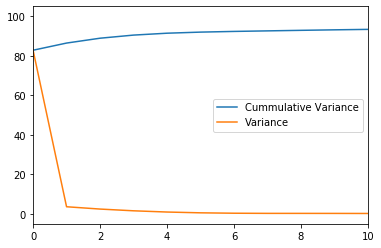

In [37]:
# 画出累计贡献率的图
plt.plot(variance.cumsum()*100.0,label="Cummulative Variance")
plt.plot(variance*100.0,label="Variance")
plt.xlim(0,10,1)
plt.legend()

In [38]:
## Define a simple map plot function for convinience
def plotmapcolor(var,vlats,vlons):
    import matplotlib.pyplot as plt
    import mpl_toolkits
    import mpl_toolkits.basemap
    import numpy as np
    map = mpl_toolkits.basemap.Basemap(llcrnrlon=vlons.min(),llcrnrlat=vlats.min(),urcrnrlon=vlons.max(),urcrnrlat=vlats.max(),projection='cyl')
    map.drawcoastlines()
    longrid,latgrid = np.meshgrid(vlons,vlats)
    x,y=map(longrid,latgrid)
    map.contourf(x,y,var,15,cmap=plt.cm.hot_r)
    plt.colorbar(shrink=0.7)

### 第一模态

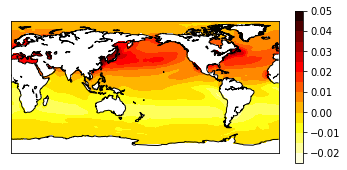

In [39]:
plotmapcolor(eof1[0,:,:],lats,lons)

#### Question: What physical mode does the plot of EOF1 above represent? 

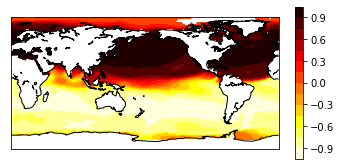

In [40]:
plotmapcolor(eof1asCorr[0,:,:],lats,lons) # Eof1 expressed as correlation between PC1 and SST anamolies

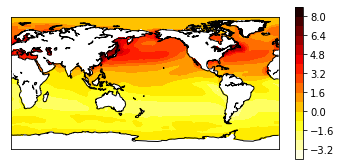

In [41]:
plotmapcolor(eof1asCov[0,:,:],lats,lons) # Eof1 expressed as covariance between PC1 and SSt anamolies

### 时间序列

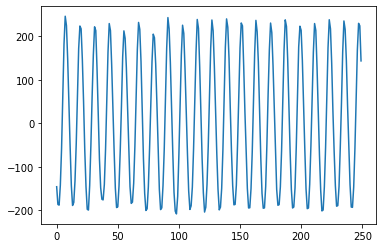

In [45]:
plt.plot(pcs[0:250])

### 第二模态

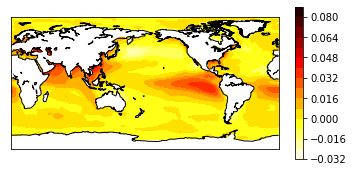

In [42]:
eof2 = solver.eofs(neofs=2)[1,:,:]
plotmapcolor(eof2,lats,lons)